In [7]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
from google.transit import gtfs_realtime_pb2
from google.protobuf.json_format import Parse, MessageToJson
import json
import psycopg2
import time
from django.contrib.gis.geos import Point, fromstr, GEOSGeometry
from datetime import datetime
import geopandas as gpd
# from haversine import haversine, Unit

dir = Path.cwd()
outdir = os.path.join(dir, 'output')
gtfs_records_zip = os.path.join(dir, 'data', 'GtfsRRecords.zip')
gtfs_csv_zip = os.path.join(outdir, 'gtfsr_csv_test.zip')
gtfs_final_csv_path = os.path.join(outdir, 'gtfsr_test.csv')

conn = psycopg2.connect(
    host="localhost",
    port='25432',
    database="gis",
    user="docker",
    password="docker"
)


In [8]:
def run_query(query: str = ''):
    """ Connect to the PostgreSQL database server """
    try:
        # connect to the PostgreSQL server
		
        # create a cursor
        cur = conn.cursor()
        
	    # execute a statement
        cur.execute(query)
        data = cur.fetchall()

        colnames = [desc[0] for desc in cur.description]
        print(colnames)
       
	    # close the communication with the PostgreSQL
        cur.close()
        return data
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()

# print(run_query())

<AxesSubplot:>

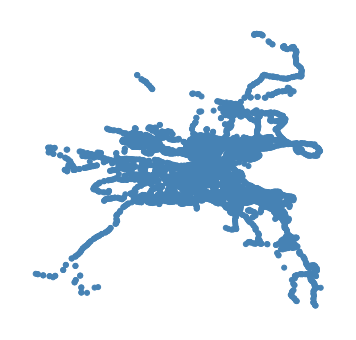

In [9]:
# get all the stop data and add the lat lon columns
import geoplot

def get_stops_df(): 
    query = """select stop_id, point as geom from stop;"""
    # res = run_query(query)

    # stop_data = []
    # for s in res:
    #     id, coords = s[0], GEOSGeometry(s[1]).coords
    #     lon, lat = coords[1], coords[0]

    #     stop_data.append([id, lon, lat])

    # return pd.DataFrame(stop_data, columns=['stop_id', 'lon', 'lat'])
    return gpd.GeoDataFrame.from_postgis(query, conn)
stop_df = get_stops_df()
# stop_df
geoplot.pointplot(stop_df)

<AxesSubplot:>

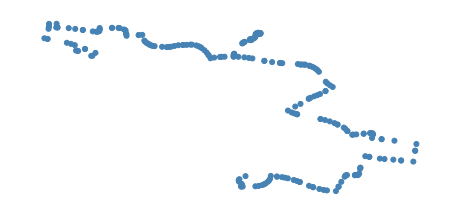

In [38]:
# get all the stop data and add the lat lon columns
def get_shape_points_df(trip_id= '7218.10455.2-104-gad-1.83.O'): 
    query = """
    select shape_point.id, shape_point.point as geom, shape_point.sequence, shape_point.traveled,
        trip.trip_id, trip.shape_id
    from shape_point 
    join shape on shape.id = shape_point.shape_id
    join trip on shape.id = trip.shape_id
    where 
        trip.trip_id = '{}'
    group by trip.id, shape_point.id
    ;
    """.format(trip_id).lstrip()

    df = gpd.GeoDataFrame.from_postgis(query, conn)
    return df

shape_p_df = get_shape_points_df()
# shape_p_df
geoplot.pointplot(shape_p_df)

In [165]:
# here we split the data into smaller chunks by getting rid
# of what we dont need
def process_gtfsr():
    __file__ = Path().cwd()

    start = time.time()

    gtfsRecords = os.path.join(__file__, 'GtfsRRecords.zip')

    query = """select trip_id from trip;"""
    trip_id_list = [id[0].replace('-d12-', '-b12-', 1)
                    for id in run_query(query)]

    # write to a new records file which we can then use to process data faster
    with zipfile.ZipFile(os.path.join(__file__, 'gtfsr_csv.zip'), 'w') as zf:

        # read from the gtfs records
        with zipfile.ZipFile(gtfsRecords, 'r') as zip:
            dirs = zip.namelist()
            dirs_len = len(dirs)

            for i in range(15, 17):
                feed = gtfs_realtime_pb2.FeedMessage()
                entity_data = []

                try:
                    realtime_data = zip.read(dirs[i])
                    Parse(realtime_data, feed)
                except:
                    print('{}.json is a bad file, continue'.format(i))
                    continue

                for entity in feed.entity:
                    if entity.HasField('trip_update'):
                        trip_id = entity.trip_update.trip.trip_id

                        if trip_id in trip_id_list:
                            trip = entity.trip_update.trip
                            stop_time_update = entity.trip_update.stop_time_update

                            for s in stop_time_update: 
                                arr = s.arrival.delay if s.HasField('arrival') else 0
                                entity_data.append([trip.trip_id, trip.start_date, trip.start_time, s.stop_sequence, s.departure.delay, s.stop_id, arr])

                if i % 100 == 0:
                    print('{}/{}'.format(i, dirs_len),
                        'time: {}s'.format(round(time.time() - start)))

                if len(entity_data) > 0:
                    # create the entity
                    entity_df = pd.DataFrame(entity_data, columns=['trip_id', 'start_date', 'start_time', 'stop_sequence', 'departure', 'stop_id', 'arrival'])
                    df = pd.merge(entity_df, stop_df, on=['stop_id'])
                    del df['stop_id']

                    # return MessageToJson(feed)
                    zf.writestr("{}.csv".format(i), df.to_csv(header=False, index=False),
                                compress_type=zipfile.ZIP_DEFLATED)

    print('finished processing')
    return
process_gtfsr()
# data = process_gtfsr()

Index(['trip_id', 'start_date', 'start_time', 'stop_sequence', 'departure',
       'arrival', 'lon', 'lat'],
      dtype='object')
Index(['trip_id', 'start_date', 'start_time', 'stop_sequence', 'departure',
       'arrival', 'lon', 'lat'],
      dtype='object')
finished processing


In [160]:
feed = gtfs_realtime_pb2.FeedMessage()
Parse(data, feed)
entity_data = []

for entity in feed.entity: 
    trip = entity.trip_update.trip
    stop_time_update = entity.trip_update.stop_time_update

    for s in stop_time_update: 
        arr = s.arrival.delay if s.HasField('arrival') else 0
        entity_data.append([trip.trip_id, trip.start_date, trip.start_time, s.stop_sequence, s.departure.delay, s.stop_id, arr])

entity_df = pd.DataFrame(entity_data, columns=['trip_id', 'start_date', 'start_time', 'stop_sequence', 'departure', 'stop_id', 'arrival'])
entity_df

,trip_id,start_date,start_time,stop_sequence,departure,stop_id,arrival
0,1149518.7.10-32-e19-1.93.O,20210109,14:45:00,1,0,8220B1350002,0
1,1149518.7.10-32-e19-1.93.O,20210109,14:45:00,2,7380,8240B111931,7260
2,1149518.7.10-32-e19-1.93.O,20210109,14:45:00,3,7620,8300B1524301,7560
3,1149518.7.10-32-e19-1.93.O,20210109,14:45:00,4,7260,8540B6012201,7260
4,1149518.7.10-32-e19-1.93.O,20210109,14:45:00,5,7140,8540B1559301,7140
...,...,...,...,...,...,...,...
1564,1154197.7.10-301-e19-1.1156.O,20210109,19:55:00,1,0,8400B6090201,0
1565,11496.10846.2-331-ga2-1.260.I,20210109,19:55:00,1,0,8240DB003815,0
1566,11496.10846.2-331-ga2-1.260.I,20210109,19:55:00,62,0,8240DB007348,0
1567,12828.10846.2-451-ga2-1.308.O,20210109,19:55:00,1,0,8350DB004533,0


In [145]:
df = pd.merge(entity_df, stop_df, on=['stop_id'])
del df['stop_id']
df

,trip_id,start_date,start_time,stop_sequence,departure,schedule,lon,lat
0,11777.2.60-13-b12-1.22.I,20210109,18:00:00,1,0,0,0.930786,-0.112593
1,11756.2.60-13-b12-1.22.I,20210109,18:15:00,1,0,0,0.930786,-0.112593
2,11370.2.60-13-b12-1.23.I,20210109,19:00:00,1,0,0,0.930786,-0.112593
3,11379.2.60-13-b12-1.19.O,20210109,18:00:00,1,0,0,0.932315,-0.109583
4,11394.2.60-13-b12-1.19.O,20210109,18:15:00,1,0,0,0.932315,-0.109583
...,...,...,...,...,...,...,...,...
104,8299.2.60-120-b12-1.59.O,20210109,19:15:00,1,0,0,0.931184,-0.109267
105,7510.2.60-130-b12-1.73.O,20210109,19:20:00,1,0,0,0.931114,-0.109202
106,7485.2.60-130-b12-1.74.I,20210109,19:20:00,1,0,0,0.931395,-0.108298
107,10746.2.60-47-b12-1.43.O,20210109,19:30:00,1,0,0,0.931078,-0.109162


In [168]:
def combine_csv():
    __file__ = Path().cwd()

    start = time.time()

    gtfs_csv_zip = os.path.join(__file__, 'gtfsr_csv.zip')
    columns = ['trip_id', 'start_date', 'start_time', 'stop_sequence', 'departure', 'arrival', 'lon', 'lat']

    # read from the gtfs records
    with zipfile.ZipFile(gtfs_csv_zip, 'r') as zip:
        dirs = zip.namelist()
        dirs_len = len(dirs)

        combined_csv = pd.concat([pd.read_csv(zip.open(f),header=None) for f in dirs])
        combined_csv.columns = columns
        combined_csv.to_csv('gtfsr_combined_csv.csv', index=False, header=True)
  
    print('finished cobining the zip files, time: {}'.format(round(time.time() - start)))
    return
combine_csv()

finished cobining the zip files, time: 0


In [18]:
run_query('select * from shape_point limit 1')

['id', 'point', 'sequence', 'traveled', 'extra_data', 'shape_id']


[(15920413,
  '0101000020E61000004301C8D260F718C0DAC62F98C0B64A40',
  1,
  0.0,
  '{}',
  33204)]

In [6]:
import itertools

# lets return a iterable that can be chunked
def chunked_iterable(iterable, size):
    it = iter(iterable)
    while True:
        chunk = tuple(itertools.islice(it, size))
        if not chunk:
            break
        yield chunk

In [73]:
from joblib import delayed, Parallel, dump
import re
from io import StringIO


def find_trip_regex(trip_list, trip_id):
    assert type(trip_id) == str, 'trip_id must be string'

    tokens = trip_id.split('.')
    if not len(tokens) == 5:
        return None

    route_id = tokens[2].split('-')
    if route_id[2] in ['ga2', 'gad']:
        route_id[2] = 'ga[2|d]'
        tokens[2] = '-'.join(route_id)
    elif route_id[2] in ['d12', 'b12']: 
        route_id[2] = '[b|d]12'
        tokens[2] = '-'.join(route_id)

    tokens[3] = '*'

    reg = '.'.join(tokens)

    r = re.compile(reg)
    matched_list = list(filter(r.match, trip_list))

    if len(matched_list) > 0:
        return matched_list[0]
    else: return None

# splits from the main processing in order to allow multiple threads and cores
# for performance reasons
def multi_compute(i, data, trip_id_list, stop_df):
    feed = gtfs_realtime_pb2.FeedMessage()
    entity_data = []

    try:
        Parse(data, feed)
    except:
        print('{}.json is a bad file, continue'.format(i))
        return

    # get feed timestamp and iterate through all the entities
    timestamp = datetime.fromtimestamp(feed.header.timestamp)
    for entity in feed.entity:
        if entity.HasField('trip_update'):
            trip_id = find_trip_regex(trip_id_list, entity.trip_update.trip.trip_id)

            # if the trip id exists in our database when can then continue processing
            if not trip_id == None:
                trip = entity.trip_update.trip
                stop_time_update = entity.trip_update.stop_time_update

                # for every stop_time_update we append add the fields needed
                for s in stop_time_update:
                    arr = s.arrival.delay if s.HasField(
                        'arrival') else 0
                    entity_data.append(
                        [trip_id, trip.start_date, trip.start_time, s.stop_sequence, int(s.departure.delay), arr, timestamp, s.stop_id])

    # only if we have an existing trip in the feed we can produce a csv file
    if len(entity_data) > 0:
        # create the entity
        entity_df = pd.DataFrame(entity_data, columns=[
            'trip_id', 'start_date', 'start_time', 'stop_sequence', 'departure', 'arrival', 'timestamp', 'stop_id'])

        # merge the entity stop_id data with the stop lat lon from database
        df = pd.merge(entity_df, stop_df, on=['stop_id'])

        # zf = zipfile.ZipFile(gtfs_csv_zip, 'a')
        # zf.writestr("{}.csv".format(i), df.to_csv(header=False, index=False), compress_type=zipfile.ZIP_DEFLATED)
        return df


# here we split the data into smaller chunks by getting rid
# of what we dont need, this is done by only including the trips where
# we have a match in our database and disregarding the rest
def process_gtfsr_to_csv(chunk_size=1000):
    start = time.time()
    stop_df = get_stops_df()

    query = """select trip_id from trip;"""
    trip_id_list = [id[0] for id in run_query(query)]

    zipfile.ZipFile(gtfs_csv_zip, 'w').close()

    # read from the gtfs records
    with zipfile.ZipFile(gtfs_records_zip, 'r') as zip:
        dirs = zip.namelist()
        dirs_len = len(dirs)
        
        # return multi_compute(1, zip.read(dirs[19]), trip_id_list, stop_df)

        curr_i = 0
        for c in chunked_iterable(dirs, size=chunk_size):
            # friendly printing to update user
            print('{}/{}'.format(curr_i, dirs_len),
                    'time: {}s'.format(round(time.time() - start)))

            # [multi_compute(curr_i+i, zip.read(dir), trip_id_list, stop_df) for i, dir in enumerate(c)]

            delayed_func = [delayed(multi_compute)(curr_i+i, zip.read(dir), trip_id_list, stop_df)
                            for i, dir in enumerate(c)]
            parallel_pool = Parallel(n_jobs=8)

            res = parallel_pool(delayed_func)
            # return res

            # write csv to zip
            columns = ['trip_id', 'start_date', 'start_time', 'stop_sequence', 'departure', 'arrival', 'timestamp', 'stop_id', 'lon', 'lat']        
            gtfsr_df = pd.DataFrame()
            gtfsr_df = gtfsr_df.fillna(0)
            for i, r in enumerate(res):
                if not type(r) == None:
                    temp_df = r
                    gtfsr_df = pd.concat([gtfsr_df, temp_df])

            if len(gtfsr_df) > 0:
                gtfsr_df.columns = columns
                # gtfsr_df = gtfsr_df.drop_duplicates(subset=columns[:6], keep='last')

                # return gtfsr_df
                with zipfile.ZipFile(gtfs_csv_zip, 'a') as zf:
                    zf.writestr("{}.csv".format(curr_i), gtfsr_df.to_csv(header=False, index=False), compress_type=zipfile.ZIP_DEFLATED)
            curr_i += chunk_size
            return gtfsr_df

    print('finished processing')
    return
start = time.time()
gtfsr = process_gtfsr_to_csv(100)
print(time.time() -start)
gtfsr

['stop_id', 'point']
['trip_id']
0/30152 time: 1s
77.80956411361694


In [55]:
gtfsr[gtfsr['timestamp'] == '2021-01-11 13:26:43']

,trip_id,start_date,start_time,stop_sequence,departure,arrival,timestamp,stop_id,lon,lat
0,5033.1.60-40-b12-1.206.O,20210111,12:00:00,1,0,0,2021-01-11 13:26:43,8240DB007132,53.403089,-6.304307
1,5044.1.60-40-b12-1.206.O,20210111,12:12:00,1,0,0,2021-01-11 13:26:43,8240DB007132,53.403089,-6.304307
2,5722.1.60-9-b12-1.10.O,20210111,12:12:00,1,0,0,2021-01-11 13:26:43,8240DB007132,53.403089,-6.304307
3,5796.1.60-9-b12-1.10.O,20210111,12:24:00,1,0,0,2021-01-11 13:26:43,8240DB007132,53.403089,-6.304307
15,1414.1.60-27-b12-1.151.O,20210111,11:50:00,1,0,0,2021-01-11 13:26:43,8220DB004595,53.402140,-6.172973
...,...,...,...,...,...,...,...,...,...,...
303,329.1.60-130-b12-1.74.I,20210111,13:15:00,1,0,0,2021-01-11 13:26:43,8220DB001772,53.365011,-6.205021
304,3125.1.60-79-b12-1.331.I,20210111,13:05:00,1,0,0,2021-01-11 13:26:43,8220DB002670,53.340390,-6.367557
305,1704.1.60-120-b12-1.59.O,20210111,13:15:00,1,0,0,2021-01-11 13:26:43,8220DB006004,53.352908,-6.260512
306,3139.1.60-79-b12-1.330.O,20210111,13:15:00,1,0,0,2021-01-11 13:26:43,8220DB000326,53.346554,-6.260545


In [39]:

columns = ['trip_id', 'start_date', 'start_time', 'stop_sequence', 'departure', 'arrival', 'timestamp', 'stop_id', 'lon', 'lat']

gtfsr_df = pd.DataFrame()
gtfsr_df = gtfsr_df.fillna(0)
for r in gtfsr: 
    if not r == None:
        temp_df = pd.read_csv(StringIO(r))
        temp_df.columns = columns
        gtfsr_df = pd.concat([gtfsr_df, temp_df])
gtfsr_df.columns = columns
gtfsr_df

,trip_id,start_date,start_time,stop_sequence,departure,arrival,timestamp,stop_id,lon,lat
0,5033.1.60-40-b12-1.206.O,20210111,12:00:00,1,0,0,2021-01-11 13:26:43,8240DB007132,53.403089,-6.304307
1,5044.1.60-40-b12-1.206.O,20210111,12:12:00,1,0,0,2021-01-11 13:26:43,8240DB007132,53.403089,-6.304307
2,5722.1.60-9-b12-1.10.O,20210111,12:12:00,1,0,0,2021-01-11 13:26:43,8240DB007132,53.403089,-6.304307
3,5796.1.60-9-b12-1.10.O,20210111,12:24:00,1,0,0,2021-01-11 13:26:43,8240DB007132,53.403089,-6.304307
4,5113.1.60-40-b12-1.206.O,20210111,12:24:00,1,0,0,2021-01-11 13:26:43,8240DB007132,53.403089,-6.304307
...,...,...,...,...,...,...,...,...,...,...
187,10798.2.60-42-b12-1.239.I,20210109,19:15:00,1,0,0,2021-01-09 19:31:08,8240DB003605,53.433968,-6.124919
188,8299.2.60-120-b12-1.59.O,20210109,19:15:00,1,0,0,2021-01-09 19:31:08,8220DB006004,53.352908,-6.260512
189,6799.2.60-54A-b12-1.51.I,20210109,19:15:00,1,0,0,2021-01-09 19:31:08,8230DB005161,53.270891,-6.371901
190,7485.2.60-130-b12-1.74.I,20210109,19:20:00,1,0,0,2021-01-09 19:31:08,8220DB001772,53.365011,-6.205021


In [42]:
gtfsr_df.insert
gtfsr_df.drop_duplicates(subset=['trip_id', 'start_date', 'start_time', 'stop_sequence', 'departure', 'arrival', 'stop_id'], keep='last')

,trip_id,start_date,start_time,stop_sequence,departure,arrival,timestamp,stop_id,lon,lat
0,5033.1.60-40-b12-1.206.O,20210111,12:00:00,1,0,0,2021-01-11 13:26:43,8240DB007132,53.403089,-6.304307
1,5044.1.60-40-b12-1.206.O,20210111,12:12:00,1,0,0,2021-01-11 13:26:43,8240DB007132,53.403089,-6.304307
2,5722.1.60-9-b12-1.10.O,20210111,12:12:00,1,0,0,2021-01-11 13:26:43,8240DB007132,53.403089,-6.304307
3,5796.1.60-9-b12-1.10.O,20210111,12:24:00,1,0,0,2021-01-11 13:26:43,8240DB007132,53.403089,-6.304307
15,1414.1.60-27-b12-1.151.O,20210111,11:50:00,1,0,0,2021-01-11 13:26:43,8220DB004595,53.402140,-6.172973
...,...,...,...,...,...,...,...,...,...,...
187,10798.2.60-42-b12-1.239.I,20210109,19:15:00,1,0,0,2021-01-09 19:31:08,8240DB003605,53.433968,-6.124919
188,8299.2.60-120-b12-1.59.O,20210109,19:15:00,1,0,0,2021-01-09 19:31:08,8220DB006004,53.352908,-6.260512
189,6799.2.60-54A-b12-1.51.I,20210109,19:15:00,1,0,0,2021-01-09 19:31:08,8230DB005161,53.270891,-6.371901
190,7485.2.60-130-b12-1.74.I,20210109,19:20:00,1,0,0,2021-01-09 19:31:08,8220DB001772,53.365011,-6.205021


In [74]:
columns[:6]

['trip_id',
 'start_date',
 'start_time',
 'stop_sequence',
 'departure',
 'arrival',
 'timestamp',
 'stop_id']

In [79]:
import dask.dataframe as dd                
import pandas as pd

df = dd.from_pandas(gtfsr_df, npartitions=1) 
df.drop_duplicates(columns[:6]).compute()

,trip_id,start_date,start_time,stop_sequence,departure,arrival,timestamp,stop_id,lon,lat
0,5033.1.60-40-b12-1.206.O,20210111,12:00:00,1,0,0,2021-01-11 13:26:43,8240DB007132,53.403089,-6.304307
0,1466.1.60-27-b12-1.151.O,20210111,13:20:00,1,0,0,2021-01-11 14:49:14,8220DB004595,53.402140,-6.172973
0,6364.1.60-13-b12-1.18.O,20210111,13:18:00,1,0,0,2021-01-11 14:15:18,8240DB006235,53.418167,-6.277031
0,6356.1.60-13-b12-1.18.O,20210111,13:30:00,1,0,0,2021-01-11 15:01:38,8240DB006235,53.418167,-6.277031
0,11756.2.60-13-b12-1.22.I,20210109,18:15:00,1,0,0,2021-01-09 19:28:02,8230DB007229,53.330089,-6.451083
...,...,...,...,...,...,...,...,...,...,...
326,3739.1.60-33-b12-1.170.O,20210111,15:25:00,1,0,0,2021-01-11 15:01:38,8220DB000292,53.349200,-6.255255
327,3203.1.60-79-b12-1.331.I,20210111,13:35:00,1,0,0,2021-01-11 13:52:25,8220DB002670,53.340390,-6.367557
328,1657.1.60-120-b12-1.59.O,20210111,15:15:00,1,0,0,2021-01-11 15:01:38,8220DB006004,53.352908,-6.260512
328,2948.1.60-56A-b12-1.52.I,20210111,14:45:00,1,0,0,2021-01-11 14:49:14,8230DB004344,53.285710,-6.372417
